### Only Retweets Network

### Imports and settings

In [1]:
from pathlib import Path
import tempfile
import os
import pandas as pd
from datetime import datetime
import pytz

TMP_DIR = Path(tempfile.gettempdir())
tmp_file = TMP_DIR / "search.json"


### Functions

##### Search Function

In [32]:
def search_tweets(
    search, type_search = "" , since=None, maxresults=None, output_json = tmp_file, min_retweets=0
):
    """
    Search and download all tweets containing a specific hashtag 
    Use https://github.com/igorbrigadir/twitter-advanced-search to get a better idea of the parameters you 
    can use in your research
    """
    cmd = 'snscrape --with-entity  %s  %s --jsonl twitter-search {search} > {outputjson}'.format(
        outputjson = output_json,
        search = '"+%s %s min_retweets:%s"' % (search, type_search, str(min_retweets))
    ) % (
        "--max-results {maxresults}".format(maxresults = maxresults) if maxresults else "", 
        "--since {since}".format(since = since) if since else "", 
    )
    print(cmd)
    os.system(cmd)

In [33]:

def search_tweets(
    search, type_search = "", since=None, maxresults=None, verbose=False, minretweets=0, output_json = tmp_file
):
    """
    Search and download all tweets containing a specific hashtag 
    Use https://github.com/igorbrigadir/twitter-advanced-search to get a better idea of the parameters you 
    can use in your research
    """
    cmd = "snscrape --jsonl"
    if verbose:
        cmd += " --progress "
    if maxresults:
        if not isinstance(maxresults, int):
            raise Exception("maxresults must be an integer")
        cmd += f" --max-results {maxresults} "
    if since:
        if not isinstance(since, str):
            raise Exception("since must be a string")
        cmd += f" --since {since} "

    cmd += f''' twitter-search "{type_search} min_retweets:{minretweets} {search}" > {output_json}'''
    os.system(cmd)

In [56]:
import snscrape.modules.twitter as sntwitter


In [82]:
tweet.user.username
tweet.user.id
tweet.retweetCount
tweet.retweetedTweet.date
tweet.retweetedTweet.url
tweet.retweetedTweet.user.username
tweet.retweetedTweet.user.id

2383844606

In [79]:
tweet.retweetedTweet

Tweet(url='https://twitter.com/Portes_Thomas/status/1462779321823735818', date=datetime.datetime(2021, 11, 22, 13, 45, 42, tzinfo=datetime.timezone.utc), content='Armée dans les quartiers, tests osseux sur les mineurs, contrôle de français … La seule chose qui manque au débat des Républicains ce sont deux chaises pour #Zemmour et Marine Le Pen. #DebatLR https://t.co/uOfO0Yi5QX', renderedContent='Armée dans les quartiers, tests osseux sur les mineurs, contrôle de français … La seule chose qui manque au débat des Républicains ce sont deux chaises pour #Zemmour et Marine Le Pen. #DebatLR https://t.co/uOfO0Yi5QX', id=1462779321823735818, user=User(username='Portes_Thomas', id=2383844606, displayname='Thomas Portes', description='Porte-parole national de @GenerationsMVT. Président de @ONextdroite et auteur de au «@CoeurDeLaHaine». T.me/PortesThomas', rawDescription='Porte-parole national de @GenerationsMVT. Président de @ONextdroite et auteur de au «@CoeurDeLaHaine». https://t.co/ZUuQRHjhJc

In [67]:
def search_load_tweets(
    keyword, type_search="", since = None, maxresults=None, minretweets=0
):
    search = f"{keyword} min_retweets:{minretweets} {type_search}"
    if since:
        search += f" since:{since}"
    for i,tweet in  enumerate(sntwitter.TwitterSearchScraper(search).get_items()):
        print(tweet.date, tweet.id, tweet.content)
        if maxresults and i > maxresults:
            break
        
    

2021-11-23 16:16:14+00:00 1463179594207485954 RT @DamienRieu: Si les #LR savaient qui est vraiment Xavier... #DebatLR https://t.co/dT27eD9btS
2021-11-23 16:14:44+00:00 1463179217328353284 RT @marcduweb: #DebatLR : #XBertrand et #PJuvin ont annoncé qu'ils voteront Macron au 2nd tour face à Zemmour. On attend avec impatience le…
2021-11-23 16:13:05+00:00 1463178803396681731 RT @slerudulier: .@ECiotti : « le message est simple : tu touches un uniforme, le soir tu dors en prison. Tu es étranger, tu commets un dél…
2021-11-23 16:12:46+00:00 1463178721351847938 RT @romainribas2021: #DebatLR https://t.co/uNj4oqPQnu
2021-11-23 16:12:41+00:00 1463178701454065666 RT @LaFrancematuer: On imagine que le député Ciotti aurait réagi de la même manière si des manifestants avaient défilé en appelant au meurt…
2021-11-23 16:12:37+00:00 1463178685557710858 RT @Lycrem2: ➡️L’ensemble des candidats à l’investiture @lesRepublicains qui disent ce qu’il faut faire sur la #sécurité,alors que le bilan…
2021-11-23

2021-11-23 14:29:49+00:00 1463152815241666573 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 14:29:24+00:00 1463152709633257476 RT @ECiotti: Oui je suis en colère ! 

Une fatwa contre @ZemmourEric ?

Aucune réaction du président et de ses ministres. 

Parce que c’est…
2021-11-23 14:29:24+00:00 1463152708790140942 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 14:29:00+00:00 1463152609406107652 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 14:26:39+00:00 1463152018621673487 RT @romainribas2021: #DebatLR https://t.co/uNj4oqPQnu
2021-11-23 14:23:49+00:00 1463151303803158528 RT @romainribas2021: #DebatLR https://t.co/uNj4oqPQnu
2021-11-23 14:21:44+00:00 1463150777640407040 RT @ToriT

2021-11-23 12:58:56+00:00 1463129943890669568 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 12:57:00+00:00 1463129456013361157 RT @marcduweb: #DebatLR : #XBertrand et #PJuvin ont annoncé qu'ils voteront Macron au 2nd tour face à Zemmour. On attend avec impatience le…
2021-11-23 12:55:06+00:00 1463128976105345035 RT @AvecJuvin: @ContexteEnvi Ce n'est pas faute d'avoir insisté pour en parler. Philippe Juvin l'a même redemandé en introduction du dernie…
2021-11-23 12:53:31+00:00 1463128577214459907 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 12:53:01+00:00 1463128451150495748 RT @ECiotti: Oui je suis en colère ! 

Une fatwa contre @ZemmourEric ?

Aucune réaction du président et de ses ministres. 

Parce que c’est…
2021-11-23 12:51:43+00:00 1463128126347694085 RT @DamienRieu: Si le

2021-11-23 11:59:15+00:00 1463114924322959377 RT @ellensalvi: Deux heures de débats sur le voile, l’écriture inclusive, l’immigration, le wokisme, le déploiement de l’armée dans les qua…
2021-11-23 11:58:25+00:00 1463114711390695427 RT @kevinbossuet: Dans un monde sain, les parents éduquent et les professeurs instruisent. Sans éducation, l'instruction devient impossible…
2021-11-23 11:58:02+00:00 1463114617580834820 RT @kevinbossuet: Dans un monde sain, les parents éduquent et les professeurs instruisent. Sans éducation, l'instruction devient impossible…
2021-11-23 11:57:54+00:00 1463114582478757888 RT @slerudulier: .@ECiotti : « le message est simple : tu touches un uniforme, le soir tu dors en prison. Tu es étranger, tu commets un dél…
2021-11-23 11:57:24+00:00 1463114455215181829 RT @marcduweb: #DebatLR : #XBertrand et #PJuvin ont annoncé qu'ils voteront Macron au 2nd tour face à Zemmour. On attend avec impatience le…
2021-11-23 11:56:28+00:00 1463114221777043457 RT @kevinbossuet: D

2021-11-23 10:38:42+00:00 1463094652895215620 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 10:38:17+00:00 1463094545458114560 RT @Ghalitnj: Quand tu demandes aux candidats @lesRepublicains de parler de leur programme ... 

#DebatLR #debatdeladroite #cnews #CongresL…
2021-11-23 10:38:06+00:00 1463094501531176964 RT @florencedesruol: #AlainMinc : Hier lors du #débatLR @cnews, on avait une équipe de rugby. Le 4 déc, le candidat désigné sera ensuite so…
2021-11-23 10:37:51+00:00 1463094438515851265 RT @teammoderes: .@xavierbertrand ne propose RIEN pour la France. #DebatLR https://t.co/Gk3b2ElOVP
2021-11-23 10:37:14+00:00 1463094281573388288 RT @teammoderes: .@vpecresse, sa seule ambition ? Copier Chirac. #DebatLR https://t.co/D0mVdtKe4W
2021-11-23 10:37:03+00:00 1463094235847180289 RT @teammoderes: .@philippejuvin, sa seule mesure dans les débats ? Exister. #DebatLR https://t.co/sWmFUf

2021-11-23 09:45:29+00:00 1463081260415426564 RT @ECiotti: Les propos de Jean Christophe Lagarde contre Éric Zemmour sont une ignominie ! 

Je m’étonne que le parquet ne se soit pas déj…
2021-11-23 09:40:14+00:00 1463079939352186883 RT @kevinbossuet: Bravo à @ECiotti d’évoquer l’#antisémitisme islamique. A certains endroits, les Juifs fuient pour ne pas se faire agresse…
2021-11-23 09:38:29+00:00 1463079498220457984 RT @MAPICOS: #Fiscalite La #flattax à 15% n’est pas une utopie : Elle rapporterait plus que l’impôt sur le revenu actuel cumulé à la CSG Le…
2021-11-23 09:36:51+00:00 1463079085442277379 RT @Jeunes_avec_VP: ✅ 708 jeunes LR s'engagent derrière @vpecresse pour ce #CongrèsLR ! 

Vous êtes de plus en plus nombreux à nous rejoind…
2021-11-23 09:34:57+00:00 1463078606012403715 RT @MichelBarnier: Je le dis aux militants des Républicains: vous allez choisir le prochain Président de la République. 

Pour gagner il fa…
2021-11-23 09:31:14+00:00 1463077674193231873 RT @gabriellecluzel

2021-11-23 08:42:20+00:00 1463065367216103431 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 08:42:19+00:00 1463065361700560897 RT @MarleneSchiappa: 🎙 « Le #DebatLR c’était 50 nuances d’Eric Zemmour : les candidats ont couru après ses positions ! Dire « nous sommes u…
2021-11-23 08:41:37+00:00 1463065187242717185 RT @CBarrely: Non Monsieur, vous ne comprenez rien du tout, vous ne ressentez rien du tout en dehors de vos démangeaisons de nombril. Votre…
2021-11-23 08:41:08+00:00 1463065064437600258 RT @ArmelePortelli: Très bon résumé de @MarleneSchiappa du #DebatLR 
@Europe1 @SoMabrouk https://t.co/lkLtHmMyWX
2021-11-23 08:40:31+00:00 1463064909072195585 RT @LeaFbpe: Par ce petit dessin savoureux, @xaviergorce nous fait un briefing pour toutes celles et ceux qui auraient raté le #debatLR 😴 h…
2021-11-23 08:39:35+00:00 1463064675688538113 RT @othmannasrou: Pas mieux. #debatLR #Pecresse2

2021-11-23 07:57:45+00:00 1463054147998171137 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 07:57:35+00:00 1463054106944229382 RT @EnsembleEMacron: #MerciMacron « Les gagnants du quinquennat d’Emmanuel Macron ce sont les Françaises et les Français qui travaillent »…
2021-11-23 07:57:02+00:00 1463053966749671428 RT @kevinbossuet: Xavier #Bertrand est rigolo. Quand @laurentwauquiez tenait un discours ferme sur les questions de sécurité, il trouvait ç…
2021-11-23 07:56:24+00:00 1463053807039004675 RT @Hope13071: Le troisième débat a été suivi sur CNews par 618.000 téléspectateurs. On en comptait 838 000 le 8/11 sur Lci. #DebatLR
2021-11-23 07:55:45+00:00 1463053644258029568 RT @ECiotti: Oui je suis en colère ! 

Une fatwa contre @ZemmourEric ?

Aucune réaction du président et de ses ministres. 

Parce que c’est…
2021-11-23 07:55:36+00:00 1463053605699821572 RT @Ghalitnj: Quand tu deman

2021-11-23 07:18:44+00:00 1463044328482385920 RT @slerudulier: "Les responsables politiques doivent mesurer leurs propos. Ceux de @jclagarde sont totalement intolérables. Si un autre qu…
2021-11-23 07:18:34+00:00 1463044284949712897 RT @ECiotti: Oui je suis en colère ! 

Une fatwa contre @ZemmourEric ?

Aucune réaction du président et de ses ministres. 

Parce que c’est…
2021-11-23 07:18:12+00:00 1463044194369482754 RT @JackdEliz: Vous aurez noté comme moi que @xavierbertrand et @vpecresse se sont lâchement dérobés et ont éludé voire ignoré la pertinent…
2021-11-23 07:14:48+00:00 1463043338660159488 RT @gabriellecluzel: « Notre civilisation est supérieure aux autres » : Marlène Schiappa choquée par Philippe Juvin. Et pourtant… #DebatLR…
2021-11-23 07:14:07+00:00 1463043165930278915 RT @ArmelePortelli: Très bon résumé de @MarleneSchiappa du #DebatLR 
@Europe1 @SoMabrouk https://t.co/lkLtHmMyWX
2021-11-23 07:14:06+00:00 1463043160347660291 RT @ConflansMacron: Hier, le #DebatLR a donné li

2021-11-23 06:36:47+00:00 1463033770462822406 RT @marcduweb: #DebatLR : #XBertrand et #PJuvin ont annoncé qu'ils voteront Macron au 2nd tour face à Zemmour. On attend avec impatience le…
2021-11-23 06:34:22+00:00 1463033163303862279 RT @CarlMeeus: Pour @ECiotti les propos de @jclagarde sont « une ignominie, un appel au meurtre c’est inexcusable il doit y avoir des pours…
2021-11-23 06:34:18+00:00 1463033146216263684 RT @xavierbertrand: Aujourd’hui, la loi prévoit des peines maximales mais pas de peines minimales. Je veux modifier la Constitution afin de…
2021-11-23 06:33:38+00:00 1463032980096622592 RT @marcduweb: #DebatLR : #XBertrand et #PJuvin ont annoncé qu'ils voteront Macron au 2nd tour face à Zemmour. On attend avec impatience le…
2021-11-23 06:31:26+00:00 1463032422728093702 RT @Noesis14: Eclat de rire en entendant Xavier Bertrand proposer 50 ans de prison pour les terroristes. La majorité des terroristes sont m…
2021-11-23 06:30:16+00:00 1463032133048586245 RT @LaurentSegnis: 

2021-11-23 05:03:27+00:00 1463010281983037442 RT @avecValerie: 📺 Retrouvez les meilleurs moments du #DebatLR de @vpecresse #Pecresse2022 ⤵️🇫🇷 https://t.co/9CcyUEXUly
2021-11-23 05:01:34+00:00 1463009808399876097 RT @antoineelieLR: Ce soir en voyant ce qu’est devenu #LR, je n’ai aucun regret d’avoir quitté le parti ! Certains favorisent la politique…
2021-11-23 05:00:27+00:00 1463009528287576065 RT @antoineelieLR: Ce soir en voyant ce qu’est devenu #LR, je n’ai aucun regret d’avoir quitté le parti ! Certains favorisent la politique…
2021-11-23 04:59:52+00:00 1463009382124474374 RT @antoineelieLR: Ce soir en voyant ce qu’est devenu #LR, je n’ai aucun regret d’avoir quitté le parti ! Certains favorisent la politique…
2021-11-23 04:57:02+00:00 1463008668488769536 RT @CarlMeeus: « Faire exécuter la peine dans son pays d’origine » proposition choc de @philippejuvin qui se retrouve seul face aux autres…
2021-11-23 04:55:55+00:00 1463008386430218241 RT @antoineelieLR: Ce soir en voyant ce qu’e

2021-11-23 01:23:25+00:00 1462954909003923464 RT @marcduweb: #DebatLR : #XBertrand et #PJuvin ont annoncé qu'ils voteront Macron au 2nd tour face à Zemmour. On attend avec impatience le…
2021-11-23 01:20:19+00:00 1462954128297054208 RT @LaurentSegnis: Je rappelle à @MichelBarnier qui propose une taxe carbone aux frontières, qu’@EmmanuelMacron s’est déjà saisi de cette q…
2021-11-23 01:19:36+00:00 1462953948877312002 RT @slerudulier: .@ECiotti : « le message est simple : tu touches un uniforme, le soir tu dors en prison. Tu es étranger, tu commets un dél…
2021-11-23 01:19:17+00:00 1462953869844094980 RT @BenjaminCauchy: Ciotti, c'est carré. #DebatLR
2021-11-23 01:18:49+00:00 1462953749987663875 RT @MarleneSchiappa: 🎙 « Le #DebatLR c’était 50 nuances d’Eric Zemmour : les candidats ont couru après ses positions ! Dire « nous sommes u…
2021-11-23 01:17:43+00:00 1462953476288303109 RT @Ksmr85: Hier soir, une poignée de @JeunesReps44 partageait ensemble un moment de convivialité autour du #D

In [69]:
tweet.user.followersCount

567

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating list to append tweet data to
#tweets_list1 = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:jack').get_items()):
    if i>100:
        break
    tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# Creating a dataframe from the tweets list above 
tweets_df1 = pd.DataFrame(tweets_list1, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

#### Load tweets

In [34]:
import pytz
col_to_keep = ["date", "user", "retweetCount", "retweetedTweet", "url", "id"]
tz = pytz.timezone('UTC')

def load_tweets(path_tmp_file = tmp_file, min_retweet = 10, col_to_keep = col_to_keep, tz = tz, since = "2005-01-01"):
    """
    load tweets and keep tweets only if retweet of tweets since data 'since' and if number of retweets >= min_retweet
    """
    tweets = pd.read_json(path_tmp_file, lines=True)
    tweets = tweets[tweets["retweetCount"] >= min_retweet ]
    tweets["tweet_date"] = tweets["retweetedTweet"].apply(
        lambda x:datetime.strptime(x["date"], "%Y-%m-%dT%H:%M:%S%z")
    )
    tweets = tweets[tweets["tweet_date"] >= datetime.strptime(since, "%Y-%m-%d").replace(tzinfo=tz)]
    tweets = tweets[col_to_keep]
    tweets = tweets.rename(columns = {"id": "tweet_id"})
    tweets["tweet_id"] = tweets["tweet_id"].apply(str)
    return tweets

#### Nodes

##### Retweeted users

In [35]:
def get_retweeted_users_df(tweets):
    """
    Create dataframe of retweeted Twitter accounts
    """
    retweeted_users = tweets.loc[:, ["retweetedTweet"]]
    #remove duplicates
    retweeted_users["tweet_id"] = retweeted_users["retweetedTweet"].apply(lambda x:x["id"]).apply(str)
    retweeted_users = retweeted_users.drop_duplicates("tweet_id")
    #get most important columns
    for col in ["date", "retweetCount", "url"]:
        retweeted_users[col] = retweeted_users["retweetedTweet"].apply(lambda x:x[col])
    for col in ["username", "id"]:
        retweeted_users[col] = retweeted_users["retweetedTweet"].apply(lambda x:x["user"][col])
    #drop useless columns
    retweeted_users = retweeted_users.drop(["retweetedTweet"], axis = 1)
    #size equals total number of retweets
    retweeted_users['size']=retweeted_users.groupby(
        ['id', 'username'])['retweetCount'].transform('sum') 
    retweeted_users["role"] = "Tweet"
    return retweeted_users

##### retweeter user

In [36]:
def get_retweeter_users_df(tweets):
    """
    Create dataframe of retweeted Twitter accounts
    """
    retweeter_users = tweets.loc[:,["url", "user", "date", "tweet_id"]]
    for col in ["username", "id"]:
        retweeter_users[col] = retweeter_users["user"].apply(lambda x:x[col])
    retweeter_users["retweetCount"] = 0
    retweeter_users["size"] = 1
    retweeter_users = retweeter_users.drop("user", axis = 1)
    retweeter_users["role"] = "RT"
    retweeter_users["date"] = retweeter_users["date"].apply(str)
    retweeter_users["tweet_id"] = retweeter_users["tweet_id"].astype(str)
    return retweeter_users

##### All users

In [37]:
def create_nodes_df(tweets):
    retweeter_users = get_retweeter_users_df(tweets)
    retweeted_users = get_retweeted_users_df(tweets)
    users = pd.concat([retweeter_users, retweeted_users])
    users = users.sort_values("date", ascending = True)
    users = users.groupby(["id", "username", "size"]).agg(
        { col: lambda x: list(x) for col in ["url", "date", "tweet_id", "retweetCount", "role"]}
    ).reset_index()
    return users

#### Edges

##### Create dataframe from tweets

In [38]:
def create_edges_df(tweets, source_column = "source", target_column = "target"):
    """
    Extract edges to draw network from list of tweets (edges are thus based on retweets)
    """
    if len(tweets):
        tweets[source_column] = tweets.user.apply(lambda x:x["id"])
        tweets[target_column] = tweets.retweetedTweet.apply(lambda x:x["user"]["id"])
        #keep only relevant columns
        edges = tweets[[source_column, target_column, "date", "tweet_id"]] 
        edges["date"] = edges["date"].apply(str) 
        #drop people who retweet themselves 
        edges = edges[edges[source_column] != edges[target_column]]
        # add metadata 
        edges = edges.sort_values("date", ascending = True)
        edges["size"] = 1
        edges["tweet_id"] = edges["tweet_id"].apply(str)
        edges = edges.groupby([source_column, target_column]).agg(
            { "date": lambda x: list(x),"tweet_id": lambda x: list(x), "size": lambda x: sum(x)}
        ).reset_index()
        #
        edges["label"] = "retweeted"
    else:
        raise Exception("no tweets found")
    return edges

##### Build network


In [39]:
import networkx as nx

layout_functions = {
    "bipartite":nx.bipartite_layout,
    "circular": nx.circular_layout,
    "kamada_kawai": nx.kamada_kawai_layout,
    "planar": nx.planar_layout,
    "random": nx.random_layout,
    "shell": nx.shell_layout,
    "spring": nx.spring_layout,
    "spectral": nx.spectral_layout,
    "spiral": nx.spiral_layout,
    "multipartite": nx.multipartite_layout
}

def return_nodes_position(edges_df, type_position_algo):
    G = nx.DiGraph()
    G = nx.from_pandas_edgelist(edges_df, source = "source", target = "target", edge_attr = "size")
    position_function = layout_functions[type_position_algo]
    position = position_function(G)
    return position

##### FInal output

In [47]:
 from ast import literal_eval

In [51]:
def to_clean_output(edges, nodes, position):
    position_df = pd.DataFrame(position).T.reset_index().rename(columns = {0: "x", 1: "y", "index" : "id"})
    nodes = nodes.merge(position_df, how = "right", on = "id")
    for col in ["id", "date"]:
        nodes[col] = nodes[col].apply(str)
    for col in ["source", "target", "date"]:
        edges[col] = edges[col].apply(str)
    nodes["date"] = nodes["date"].apply(literal_eval)
    nodes["metadata"] = nodes.apply(
        lambda x:{col: x[col] for col in ['date', "tweet_id", "retweetCount", "role", "url"]}, axis=1
    )
    edges["date"] = edges["date"].apply(literal_eval)
    edges["metadata"] = edges.apply(
        lambda x:{col: x[col] for col in ['date', "tweet_id"]}, axis=1
    )
    output = {
        "edges": edges[['source', 'target', 'size', 'label', 'metadata']].to_dict('records'),
        "nodes": nodes[['id', 'username', 'size', 'metadata']].to_dict('records')
    }
    return output

In [84]:
nodes

,id,username,size,url,date,tweet_id,retweetCount,role
0,11911322,philippejuvin,35,[https://twitter.com/philippejuvin/status/1462...,[2021-11-21T22:57:08+00:00],[1462555708365455365],[35],[Tweet]
1,14159325,JustineMerieau,1,[https://twitter.com/JustineMerieau/status/146...,[2021-11-23 00:50:34+00:00],[1462946643418959873],[0],[RT]
2,14237828,MarleneSchiappa,63,[https://twitter.com/MarleneSchiappa/status/14...,[2021-11-22T08:01:22+00:00],[1462692668048396288],[63],[Tweet]
3,14473730,mouradrules,1,[https://twitter.com/mouradrules/status/146295...,[2021-11-23 01:28:01+00:00],[1462956069014093828],[0],[RT]
4,17172319,xavierbertrand,397,[https://twitter.com/xavierbertrand/status/146...,"[2021-11-21T20:10:48+00:00, 2021-11-21T20:42:3...","[1462513850922815497, 1462521853046665222, 146...","[138, 122, 137]","[Tweet, Tweet, Tweet]"
...,...,...,...,...,...,...,...,...
580,1458766672257556480,AnneBarthelemy6,1,[https://twitter.com/AnneBarthelemy6/status/14...,[2021-11-23 13:13:52+00:00],[1463133698325467146],[0],[RT]
581,1458865100660555785,nherve_,1,[https://twitter.com/nherve_/status/1462994789...,[2021-11-23 04:01:53+00:00],[1462994789725573125],[0],[RT]
582,1459219885863714826,AchilleHector73,1,[https://twitter.com/AchilleHector73/status/14...,"[2021-11-23 06:54:37+00:00, 2021-11-23 08:52:0...","[1463038260440178689, 1463067830472040452]","[0, 0]","[RT, RT]"
583,1459969026126401542,noerich19,1,[https://twitter.com/noerich19/status/14630157...,[2021-11-23 05:25:15+00:00],[1463015769218945031],[0],[RT]


### Main

#### Settings

In [52]:
search = "#DébatLR"
since = "2021-11-23"
algo = "spring"

##### Run

In [14]:
search_tweets(
    search = search,
    type_search= "filter:nativeretweets",
    since = since,
    #maxresults = 1000
)

In [53]:
tweets = load_tweets(path_tmp_file = tmp_file, min_retweet = 10, col_to_keep = col_to_keep)
edges = create_edges_df(tweets)
nodes = create_nodes_df(tweets)
position = return_nodes_position(
    edges_df = edges, 
    type_position_algo = algo
)
output = to_clean_output(edges, nodes, position)

/tmp/ipykernel_22905/741397527.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges["date"] = edges["date"].apply(str)


In [55]:
import json
with open("output_graph_test_v2.json", "w") as outfile:
    json.dump(output, outfile)

##### Plot

In [20]:
G = nx.DiGraph()
G = nx.from_pandas_edgelist(edges, source = "source", target = "target")

In [21]:
algo = "kamada_kawai"
position = return_nodes_position(
    edges_df = edges, 
    type_position_algo = algo
)

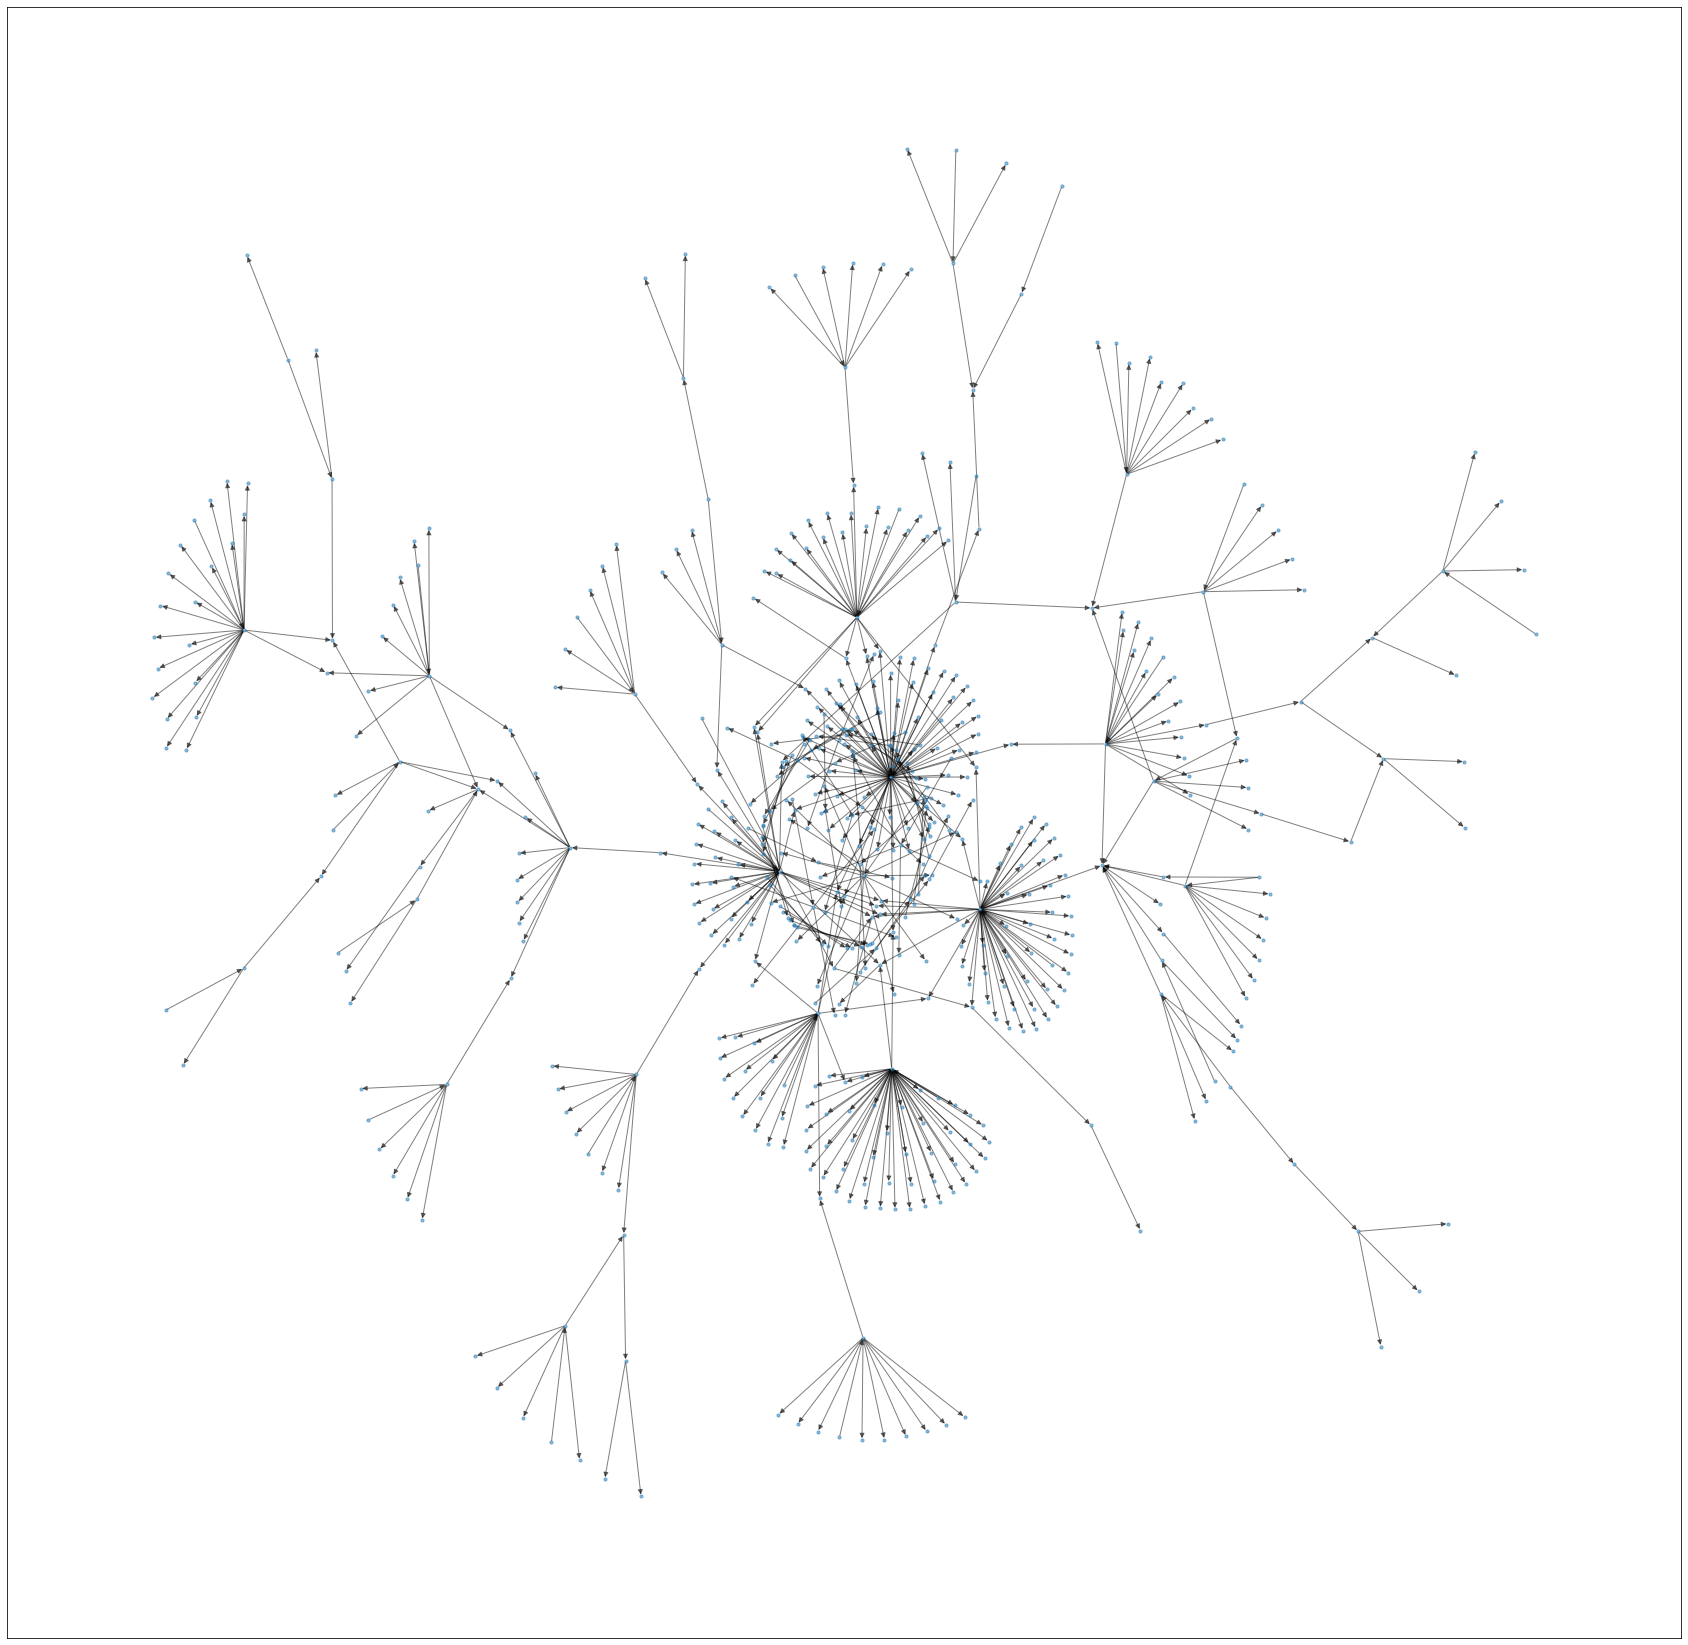

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
nx.draw_networkx(
    G, pos=position, arrows = True, with_labels = False, font_size = 15, node_size = 10, alpha = 0.5
)